# Off-Platform Project: Viral Tweets

In this project, we are going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before jumping into using the classifier, let's first consider the problem we're trying to solve. Which features of a tweet are most closely linked to its popularity? Maybe the number of hashtags or the number of links in the tweet strongly influences its popularity. Maybe its virality is dependent on how many followers the person has. Maybe it's something more subtle like the specific language used in the tweets.

Let's explore these options by looking at the data we have available to us. Let's import the dataset and print the following information:

* Total number of tweets in the dataset.
* The columns, or features, of the dataset.
* The text of the first tweet in the dataset.

Some of these features are dictionaries. For example, the feature `"user"` is a dictionary. We might want to use some of the information found in these sub-dictionaries. Let's print `all_tweets.loc[0]["user"]` to see what the `"user"` feature looks like.

After printing that, let's try printing just the `"location"` found in that `"user"` dictionary. For example, `all_tweets.loc[0]["user"]["screen_name"]` would give you only the screen name associated with the first tweet.

In [2]:
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)
print(all_tweets.loc[0]['text'])

#Print the user here and the user's location here.
print(all_tweets.loc[0]['user']['screen_name'])
print(all_tweets.loc[0]['user']['location'])


11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…
derekw221
Waterloo, Iowa


# Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, we need to have a dataset with tagged labels. For this specific example, we need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of our dataset &mdash; we'll need to make it ourselves.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has. This can be found using the feature `"retweet_count"`. Let's say we wanted to create a column called `is_viral` that is a `1` if the tweet had more than `5` retweets and `0` otherwise. We could do that like this:

Instead of using `5` as the benchmark for a viral tweet, let's use the median number of retweets.

Let's print the number of viral tweets and non-viral tweets.

We can come back later to update this threshold number and see how it affects our model.

In [23]:
import numpy as np

# Find the median number of retweets for the data set
retweet_count_median = np.median(all_tweets['retweet_count'])

# Create an is_viral data column using the median retween_count number
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > retweet_count_median, 1, 0)

# Print the not_so_viral & viral tweet counts
print(all_tweets['is_viral'].value_counts())

0    5562
1    5537
Name: is_viral, dtype: int64


# Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. For example, let's say we think the length of a tweet might be a valuable feature. The following line creates a new column containing the length of the tweet.

Let's create a new column called `followers_count` that contains the number of followers of each user. This information is found in `tweet['user']['followers_count']`. let's do the same for `friends_count`.

For the rest of this project, we will be using these three features, but we can always revisit this project and add more features. Here are some potential ideas for more features.

* The number of hashtags in the tweet. We can find this by looking at the `text` of the tweet and using the `.count()` function with `#` as a parameter.
* The number of links in the tweet. Using a similar strategy to the one above, use `.count()` to count the number of times `http` appears in the tweet.
* The number of words in the tweet. Call `.split()` on the `text` of a tweet. This will give us a list of the words in the tweet. Find the length of that list.
* The average length of the words in the tweet.

In [27]:
# Create a new column for tweet length data
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)

# Create a new column for follower count data
all_tweets['follower_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)

# Create a new column for friends count data
all_tweets['friend_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)

# Normalizing The Data

We've now made the columns that we want to feed into our classifier. Let's get rid of all the data that is no longer relevant. Let's create a variable named `labels` and set it equal to the `'is_viral'` column of all_tweets.

And a variable named `data` and set it equal to all of the columns that we created in the last step. Those columns are `tweet_length`, `followers_count`, and `friends_count`.

Next let's create a new variable named `scaled_data`. `scaled_data` should be the result of the `scale` function with `data` as a parameter. We should also include the parameter `axis = 0` to scale the *columns* as opposed to the rows.

The scale function will normalize the data so all of the features will vary within the same range.

Then let's print `scaled_data[0]` to get a sense of what our data looks like.

In [28]:
# Import the scaling fucntion form sklearn
from sklearn.preprocessing import scale

# Separat our relevant information into data and labels
labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'follower_count', 'friend_count']]

# Normalize the data with the scaling function
scaled_data = scale(data, axis=0)

# Print the scaled data to verify
print(scaled_data[0])

[ 0.6164054  -0.02878298 -0.14483305]


# Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `scaled_data` and `labels` into a training set and test set using scikit-learn's `train_test_split` function. This function takes two required parameters: It takes the data, followed by the labels. We'll set the optional parameter `test_size` to be `0.2`. We can also set the `random_state` parameter so your code will randomly split the data in the same way each time.  Remember, this function returns 4 items in this order:

1. The training data
2. The testing data
3. The training labels
4. The testing labels

We'll store the results in variables named `train_data`, `test_data`, `train_labels`, and `test_labels`.

In [33]:
# Import the function to split our data into training and testing data
from sklearn.model_selection import train_test_split

# Create our different data sets
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

# Using the Classifier

We can finally use the K-Nearest Neighbor classifier. Let's test it using `k = 5`.

We'll train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Finally, we'll test the model using `test_data` and `test_labels` and print the results.


In [34]:
# Import the K-Nearest Neighbors classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the classifier
classifier = KNeighborsClassifier(n_neighbors=5)

# Train the model with our training data
classifier.fit(train_data, train_labels)

# Print the results of the score of the model using the test data
print(classifier.score(test_data, test_labels))

0.5882882882882883


# Choosing K

We've tested our classifier with `k = 5`, but maybe there's a `k` that will work better. Let's test many different values for `k` and graph the results. 

First, we'll create an empty list called `scores`. Next, we'll create a for loop that has a variable `k` that begins at `1` and ends at `200`.

Finally, we'll's plot the results and see how k affects the accuracy of our model.

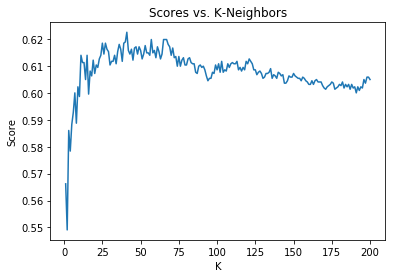

In [37]:
# Import the standard visualization library
import matplotlib.pyplot as plt

# Create an empty list for upcoming scores
scores = []

# Loop through a bunch of k's and add their scores to
# the scores list
for k in range(1,201):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))

# Plot the score vs K values to identify the best
plt.plot(range(1,201), scores)
# Add the title
plt.title('Scores vs. K-Neighbors')
# Add the axis labels
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

# Exploring More

We can see the classifier gets better as `k` increases, but as `k` gets too high, underfitting starts to happen.

By using the features `tweet_length`, `followers_count`, and `friends_count`, we were able to get up to around 63% accuracy. That is better than random, but still not exceptional. I'm sure there are more features we could add to make our model better.